In [160]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-play-store-apps/googleplaystore.csv
/kaggle/input/google-play-store-apps/license.txt
/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



In [162]:
df = pd.read_csv('/kaggle/input/google-play-store-apps/googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


# Numerical Features Cleaning and Analysis

In [164]:
def num_plots(df, col, title, xlabel):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0])
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1])
    ax[1].set_xlabel(xlabel, fontsize=16)
    plt.tight_layout()
    plt.show()

In [165]:
df = df.rename(columns=str.lower)

In [166]:
df.columns

Index(['app', 'category', 'rating', 'reviews', 'size', 'installs', 'type',
       'price', 'content rating', 'genres', 'last updated', 'current ver',
       'android ver'],
      dtype='object')

In [167]:
df[df.duplicated(subset='app')]

,app,category,rating,reviews,size,installs,type,price,content rating,genres,last updated,current ver,android ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614,37M,"10,000,000+",Free,0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989,Varies with device,"1,000,000+",Free,0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,FarmersOnly Dating,DATING,3.0,1145,1.4M,"100,000+",Free,0,Mature 17+,Dating,"February 25, 2016",2.2,4.0 and up
10720,Firefox Focus: The privacy browser,COMMUNICATION,4.4,36981,4.0M,"1,000,000+",Free,0,Everyone,Communication,"July 6, 2018",5.2,5.0 and up
10730,FP Notebook,MEDICAL,4.5,410,60M,"50,000+",Free,0,Everyone,Medical,"March 24, 2018",2.1.0.372,4.4 and up
10753,Slickdeals: Coupons & Shopping,SHOPPING,4.5,33599,12M,"1,000,000+",Free,0,Everyone,Shopping,"July 30, 2018",3.9,4.4 and up


In [168]:
df.drop_duplicates(subset='app', inplace=True, ignore_index=True)

In [169]:
df_clean = df.copy()

## Reviews column cleaning

In [170]:
print('Number of non numeric reviews :', len(df_clean) - df_clean.reviews.str.isnumeric().sum())

Number of non numeric reviews : 1


In [171]:
df[pd.to_numeric(df_clean.reviews, errors='coerce').isna()]

,app,category,rating,reviews,size,installs,type,price,content rating,genres,last updated,current ver,android ver
9300,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [172]:
df.at[9300,'category'] = np.nan
df.at[9300,'rating'] = 1.9
df.at[9300,'reviews'] = 19.0
df.at[9300,'size'] = '3.0M'
df.at[9300,'installs'] = '1,000+'
df.at[9300,'type'] = 'Free'
df.at[9300,'price'] = 0
df.at[9300,'content rating'] = 'Everyone'
df.at[9300,'genres'] = np.nan
df.at[9300,'last updated'] = 'February 11, 2018'
df.at[9300,'current ver'] = '1.0.19'
df.at[9300,'android ver'] = '4.0 and up'


In [173]:
df_clean = df_clean.drop(9300)
df_clean = df_clean.reset_index(drop=True)

In [174]:
print('Number of non numeric reviews :', len(df_clean) - df_clean.reviews.str.isnumeric().sum())

Number of non numeric reviews : 0


In [175]:
df_clean['reviews'] = df_clean['reviews'].astype('int64')

## App size column cleaning and analysis

In [176]:
df_clean['size']

0                      19M
1                      14M
2                     8.7M
3                      25M
4                     2.8M
               ...        
9654                   53M
9655                  3.6M
9656                  9.5M
9657    Varies with device
9658                   19M
Name: size, Length: 9659, dtype: object

In [177]:
df_clean[~df_clean['size'].str.contains('M', regex= True, na=False)].head()

,app,category,rating,reviews,size,installs,type,price,content rating,genres,last updated,current ver,android ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,Varies with device,"5,000,000+",Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,Varies with device,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
58,Restart Navigator,AUTO_AND_VEHICLES,4.0,1403,201k,"100,000+",Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,Varies with device,"5,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device


In [178]:
df_clean[~df_clean['size'].str.contains('[k,M,Varies with device]$', regex= True, na=False)].head()

,app,category,rating,reviews,size,installs,type,price,content rating,genres,last updated,current ver,android ver


In [179]:
df_clean['size'] = df_clean['size'].replace('Varies with device', 'NaN', regex=True)

In [180]:
df_clean['size']

0        19M
1        14M
2       8.7M
3        25M
4       2.8M
        ... 
9654     53M
9655    3.6M
9656    9.5M
9657     NaN
9658     19M
Name: size, Length: 9659, dtype: object

In [181]:
size =[]

for i in df_clean['size']:
    if i == 'NaN':
        size.append('NaN')
    elif i[-1] == 'k':
        size.append(float(i[:-1])/1000)
    else:
        size.append(float(i[:-1]))

In [182]:
df_clean['size'] = size
df_clean['size'] = df_clean['size'].astype(float)
df_clean.rename(columns={df_clean.columns[4]:'size(MB)'}, inplace=True)

In [183]:
df_clean.head()

,app,category,rating,reviews,size(MB),installs,type,price,content rating,genres,last updated,current ver,android ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


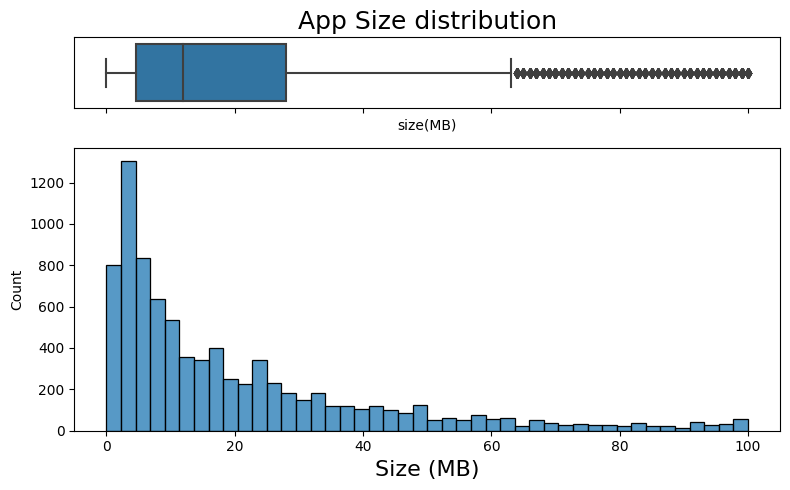

In [184]:
num_plots(df_clean,'size(MB)','App Size distribution','Size (MB)')

In [185]:
print('Average app size is: ', df_clean['size(MB)'].mean())
print('Median app size is: ', df_clean['size(MB)'].median())
print('Mode app size is: ', df_clean['size(MB)'].mode()[0])

Average app size is:  20.39528931451613
Median app size is:  12.0
Mode app size is:  11.0


## App Rating analysis

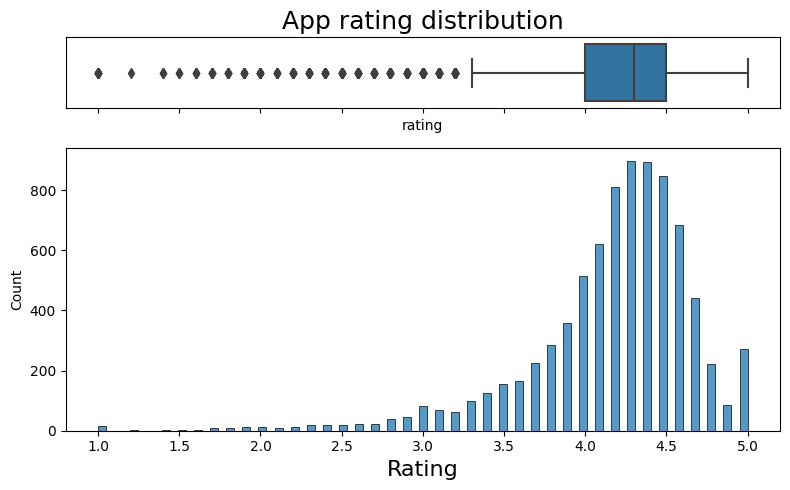

In [186]:
num_plots(df_clean,'rating','App rating distribution','Rating')

In [187]:
print('Average app rating is: ', df_clean['rating'].mean())
print('Median app rating is: ', df_clean['rating'].median())
print('Mode app rating is: ', df_clean['rating'].mode()[0])

Average app rating is:  4.173243045387994
Median app rating is:  4.3
Mode app rating is:  4.3


In [188]:
df_clean[df_clean['rating'] <= 1.0]

,app,category,rating,reviews,size(MB),installs,type,price,content rating,genres,last updated,current ver,android ver
524,House party - live chat,DATING,1.0,1,9.2,10+,Free,0,Mature 17+,Dating,"July 31, 2018",3.52,4.0.3 and up
3268,Speech Therapy: F,FAMILY,1.0,1,16.0,10+,Paid,$2.99,Everyone,Education,"October 7, 2016",1.0,2.3.3 and up
4199,Clarksburg AH,MEDICAL,1.0,1,28.0,50+,Free,0,Everyone,Medical,"May 1, 2017",300000.0.81,4.0.3 and up
4986,Truck Driving Test Class 3 BC,FAMILY,1.0,1,2.0,50+,Paid,$1.49,Everyone,Education,"April 9, 2012",1.0,2.1 and up
5311,BJ Bridge Standard American 2018,GAME,1.0,1,4.9,"1,000+",Free,0,Everyone,Card,"May 21, 2018",6.2-sayc,4.0 and up
5479,MbH BM,MEDICAL,1.0,1,2.3,100+,Free,0,Everyone,Medical,"December 14, 2016",1.1.3,4.3 and up
6100,CB Mobile Biz,FINANCE,1.0,3,8.4,500+,Free,0,Everyone,Finance,"February 22, 2016",4.4.1255,4.0 and up
6336,Thistletown CI,PRODUCTIVITY,1.0,1,6.6,100+,Free,0,Everyone,Productivity,"March 15, 2018",41.9,4.1 and up
6380,CJ DVD Rentals,COMMUNICATION,1.0,5,13.0,100+,Free,0,Everyone,Communication,"October 6, 2017",1.0,4.1 and up
6747,CR Magazine,BUSINESS,1.0,1,7.8,100+,Free,0,Everyone,Business,"July 23, 2014",2.4.2,2.3.3 and up


In [189]:
print('Apps with rating equal or lower than 1 star: ',len(df_clean[df_clean['rating'] <= 1.0]))

Apps with rating equal or lower than 1 star:  16


## App price analysis

In [190]:
df_clean['price'].isnull().sum()

0

In [191]:
df_clean['price'] = df_clean['price'].str.replace('$','').astype(float)

In [192]:
df_clean['price'].value_counts()

price
0.00      8903
0.99       145
2.99       124
1.99        73
4.99        70
          ... 
18.99        1
389.99       1
19.90        1
1.75         1
1.04         1
Name: count, Length: 92, dtype: int64

In [193]:
print('Free apps are {}% of the total apps in the dataset'.format(np.round(len(df_clean[df_clean['price']==0])*100/len(df_clean)),2))

Free apps are 92.0% of the total apps in the dataset


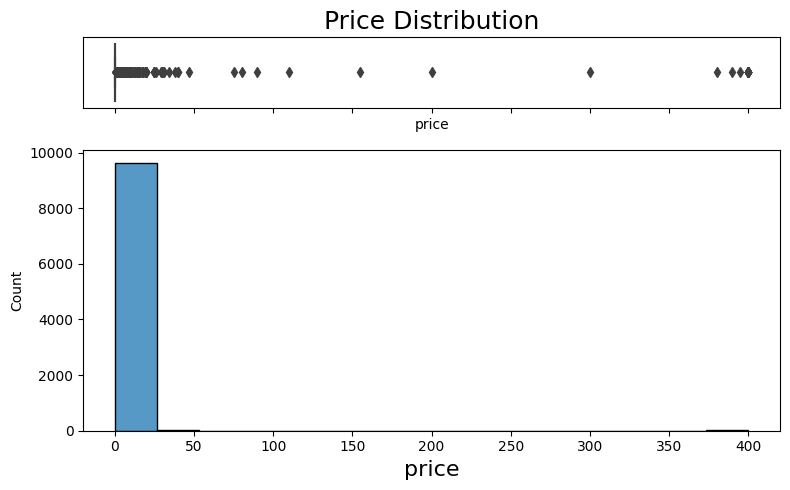

In [194]:
num_plots(df_clean,'price','Price Distribution','price')

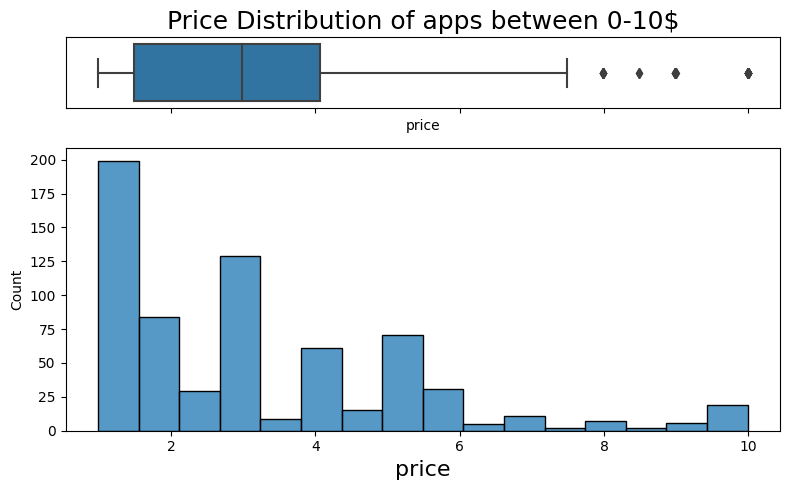

In [195]:
num_plots(df_clean[(df_clean['price']>0) & (df_clean['price']<10)],'price','Price Distribution of apps between 0-10$','price')

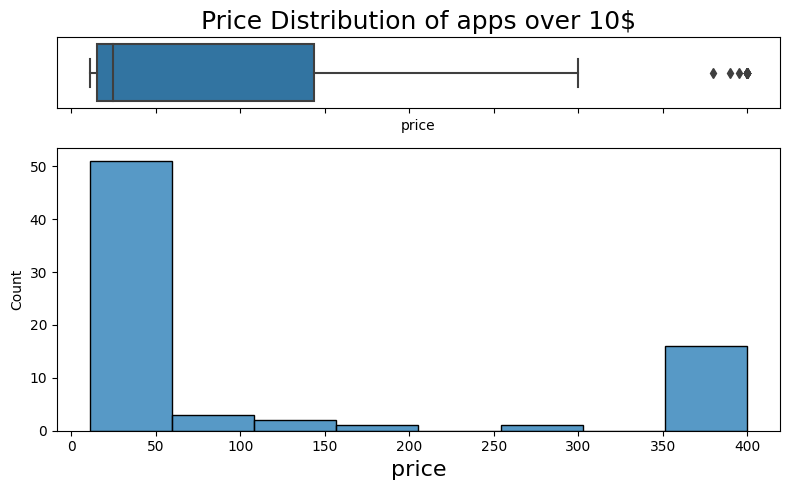

In [196]:
num_plots(df_clean[(df_clean['price']>10)],'price','Price Distribution of apps over 10$','price')

In [197]:
df_clean[df_clean['price']>350]

,app,category,rating,reviews,size(MB),installs,type,price,content rating,genres,last updated,current ver,android ver
3327,most expensive app (H),FAMILY,4.3,6,1.500,100+,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
3465,💎 I'm rich,LIFESTYLE,3.8,718,26.000,"10,000+",Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
3469,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300,"10,000+",Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
4396,I am rich,LIFESTYLE,3.8,3547,1.800,"100,000+",Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
4398,I am Rich Plus,FAMILY,4.0,856,8.700,"10,000+",Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
4400,I Am Rich Premium,FINANCE,4.1,1867,4.700,"50,000+",Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
4401,I am extremely Rich,LIFESTYLE,2.9,41,2.900,"1,000+",Paid,379.99,Everyone,Lifestyle,"July 1, 2018",1.0,4.0 and up
4402,I am Rich!,FINANCE,3.8,93,22.000,"1,000+",Paid,399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
4403,I am rich(premium),FINANCE,3.5,472,0.965,"5,000+",Paid,399.99,Everyone,Finance,"May 1, 2017",3.4,4.4 and up
4406,I Am Rich Pro,FAMILY,4.4,201,2.700,"5,000+",Paid,399.99,Everyone,Entertainment,"May 30, 2017",1.54,1.6 and up


In [198]:
df_clean[(df_clean['price']>50) & (df_clean['price']<350)]

,app,category,rating,reviews,size(MB),installs,type,price,content rating,genres,last updated,current ver,android ver
1755,Vargo Anesthesia Mega App,MEDICAL,4.6,92,32.0,"1,000+",Paid,79.99,Everyone,Medical,"June 18, 2018",19.0,4.0.3 and up
1881,Language Therapy: Aphasia,MEDICAL,NaN,10,28.0,"1,000+",Paid,74.99,Everyone,Medical,"June 25, 2018",3.1.1,4.0.3 and up
4399,I am rich VIP,LIFESTYLE,3.8,411,2.6,"10,000+",Paid,299.99,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5599,BP Fitness Lead Scanner,EVENTS,NaN,0,6.7,1+,Paid,109.99,Everyone,Events,"August 23, 2017",0.0.1,4.1 and up
5661,cronometra-br,PRODUCTIVITY,NaN,0,5.4,0+,Paid,154.99,Everyone,Productivity,"November 24, 2017",1.0.0,4.1 and up
8577,EP Cook Book,MEDICAL,NaN,0,3.2,0+,Paid,200.00,Everyone,Medical,"July 26, 2015",1.0,3.0 and up
8588,Lean EQ,BUSINESS,NaN,6,10.0,10+,Paid,89.99,Everyone,Business,"February 14, 2017",1.0,4.1 and up


In [199]:
print('Number of apps with price higher than 50$: ', len(df_clean.loc[df_clean['price']>50]))

Number of apps with price higher than 50$:  23


In [200]:
df_clean = df_clean.loc[df_clean['price'] < 50]

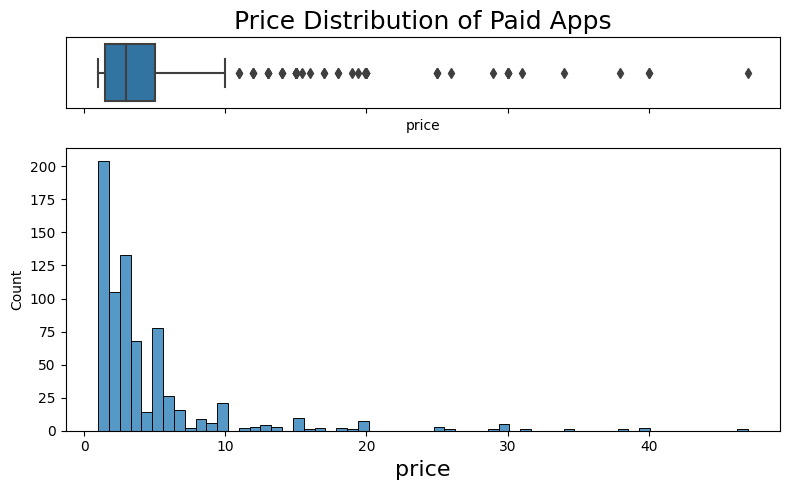

In [201]:
num_plots(df_clean.loc[df_clean['price'] > 0],'price','Price Distribution of Paid Apps','price')

In [202]:
df_clean = df_clean.loc[df_clean['price']<20]

## App install

In [203]:
df_clean['installs']

0           10,000+
1          500,000+
2        5,000,000+
3       50,000,000+
4          100,000+
           ...     
9654         5,000+
9655           100+
9656         1,000+
9657         1,000+
9658    10,000,000+
Name: installs, Length: 9620, dtype: object

In [204]:
df_clean['installs'] = df_clean['installs'].str.replace('+','').str.replace(',','').astype(float)

In [205]:
df_clean.rename(columns={df_clean.columns[5]:'Installs(+)'}, inplace=True)

<Axes: xlabel='Installs(+)', ylabel='Density'>

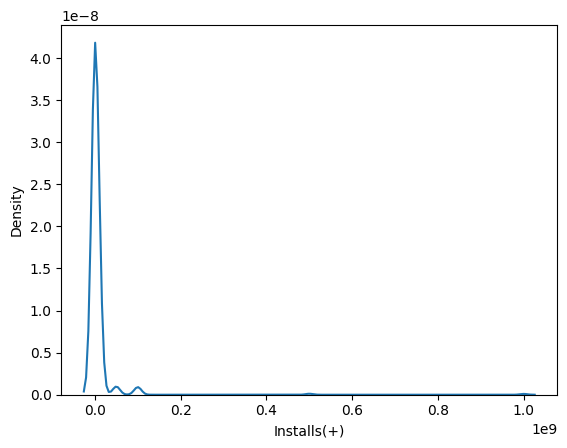

In [206]:
sns.kdeplot(x='Installs(+)', data=df_clean)

In [207]:
df_clean[df_clean['Installs(+)']> 0.8e9 ]

,app,category,rating,reviews,size(MB),Installs(+),type,price,content rating,genres,last updated,current ver,android ver
152,Google Play Books,BOOKS_AND_REFERENCE,3.9,1433233,NaN,1.000000e+09,Free,0.0,Teen,Books & Reference,"August 3, 2018",Varies with device,Varies with device
299,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,NaN,1.000000e+09,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
300,WhatsApp Messenger,COMMUNICATION,4.4,69119316,NaN,1.000000e+09,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
302,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995,NaN,1.000000e+09,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
304,Gmail,COMMUNICATION,4.3,4604324,NaN,1.000000e+09,Free,0.0,Everyone,Communication,"August 2, 2018",Varies with device,Varies with device
305,Hangouts,COMMUNICATION,4.0,3419249,NaN,1.000000e+09,Free,0.0,Everyone,Communication,"July 21, 2018",Varies with device,Varies with device
349,Skype - free IM & video calls,COMMUNICATION,4.1,10484169,NaN,1.000000e+09,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
701,Google Play Games,ENTERTAINMENT,4.3,7165362,NaN,1.000000e+09,Free,0.0,Teen,Entertainment,"July 16, 2018",Varies with device,Varies with device
1356,Subway Surfers,GAME,4.5,27722264,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
2002,Facebook,SOCIAL,4.1,78158306,NaN,1.000000e+09,Free,0.0,Teen,Social,"August 3, 2018",Varies with device,Varies with device


<Axes: xlabel='Installs(+)'>

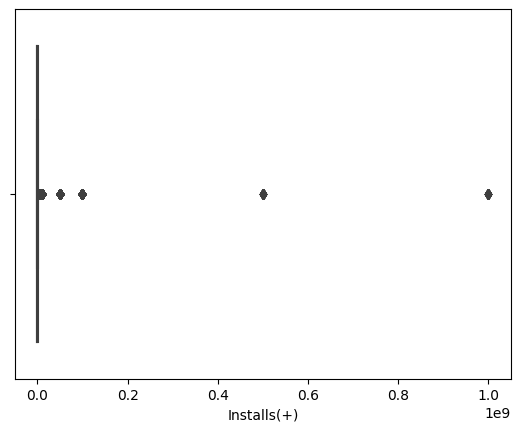

In [208]:
sns.boxplot(x='Installs(+)', data=df_clean)

In [209]:
def iqr_fence(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    u = max(x[x<Upper_Fence])
    l = min(x[x>Lower_Fence])
    return [u,l]

In [210]:
upper, lower = iqr_fence(df_clean['Installs(+)'])
print('Upper Fence:', upper)
print('Lower Fence:', lower)

Upper Fence: 1000000.0
Lower Fence: 0.0


In [211]:
print('Total apps', len(df_clean))
no_installs = [1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1]
for n in no_installs:
    print('Number of apps with less than ' + str(n) + ' installs:', len(df_clean.loc[df_clean['Installs(+)']<n]))

Total apps 9620
Number of apps with less than 1000000000.0 installs: 9600
Number of apps with less than 100000000.0 installs: 9388
Number of apps with less than 10000000.0 installs: 8249
Number of apps with less than 1000000.0 installs: 6225
Number of apps with less than 100000.0 installs: 4610
Number of apps with less than 10000.0 installs: 3118
Number of apps with less than 1000.0 installs: 1775
Number of apps with less than 100.0 installs: 740
Number of apps with less than 10.0 installs: 156


# Categorical Features Cleaning and Analysis

## Category analysis

In [212]:
print('In total there are {} different app categories'. format(len(df_clean['category'].value_counts())))

In total there are 33 different app categories


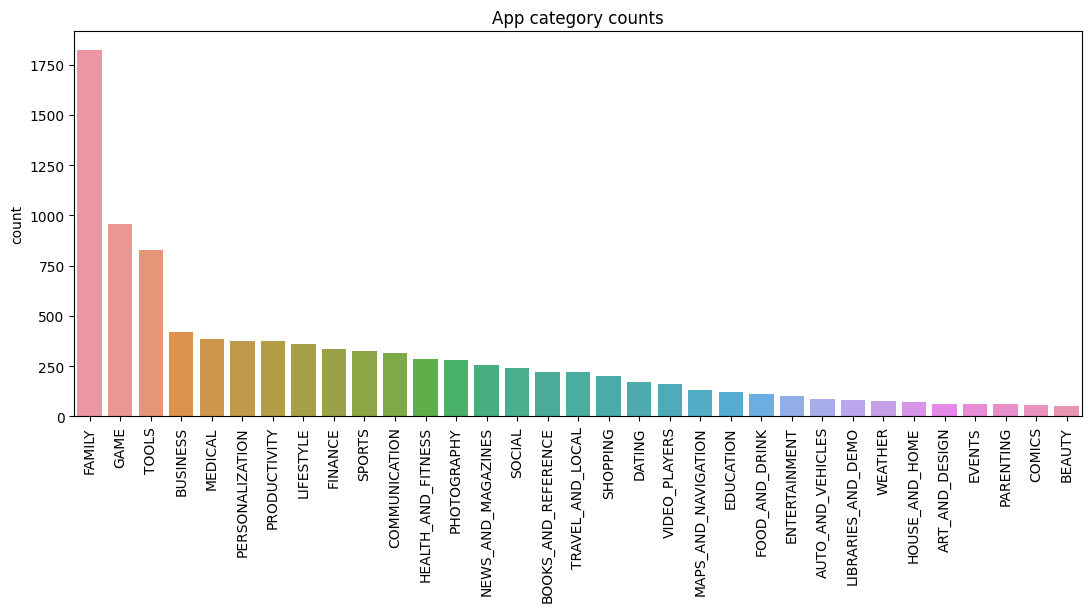

In [213]:
plt.subplots(figsize=(13,5))
sns.countplot(x='category', data=df_clean, order = df_clean['category'].value_counts().index)
plt.xticks(rotation=90);
plt.xlabel('')
plt.title('App category counts');

### Is there any difference between the category column and genres?

In [214]:
df_clean[['category','genres']]

,category,genres
0,ART_AND_DESIGN,Art & Design
1,ART_AND_DESIGN,Art & Design;Pretend Play
2,ART_AND_DESIGN,Art & Design
3,ART_AND_DESIGN,Art & Design
4,ART_AND_DESIGN,Art & Design;Creativity
...,...,...
9654,FAMILY,Education
9655,FAMILY,Education
9656,MEDICAL,Medical
9657,BOOKS_AND_REFERENCE,Books & Reference


## App type (free or paid)

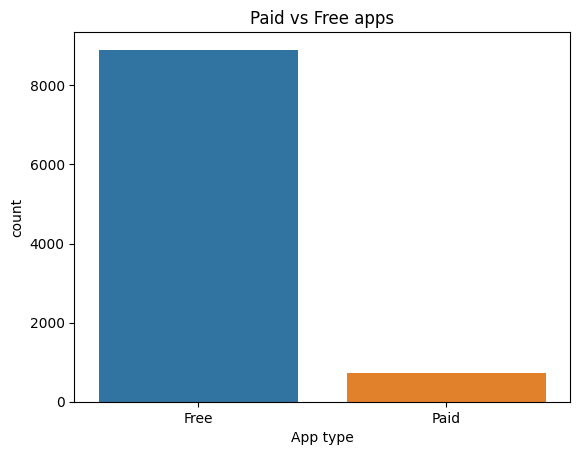

In [215]:
sns.countplot(x='type', data=df_clean)
plt.title('Paid vs Free apps')
plt.xlabel('App type')
plt.show()

## Content rating

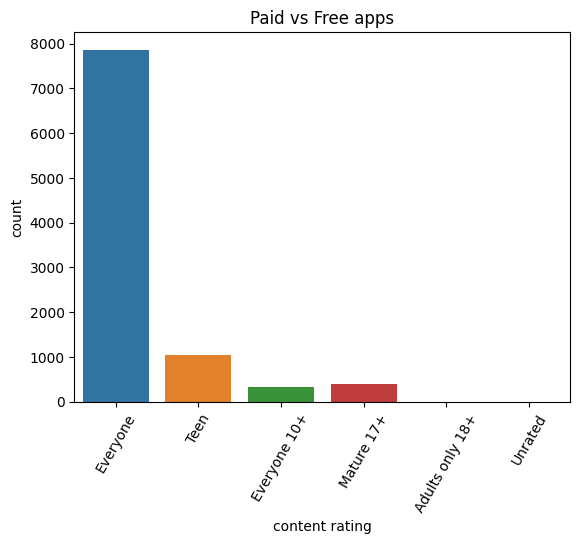

In [216]:
sns.countplot(x='content rating', data=df_clean)
plt.title('Paid vs Free apps')
plt.xticks(rotation=60)
plt.show()

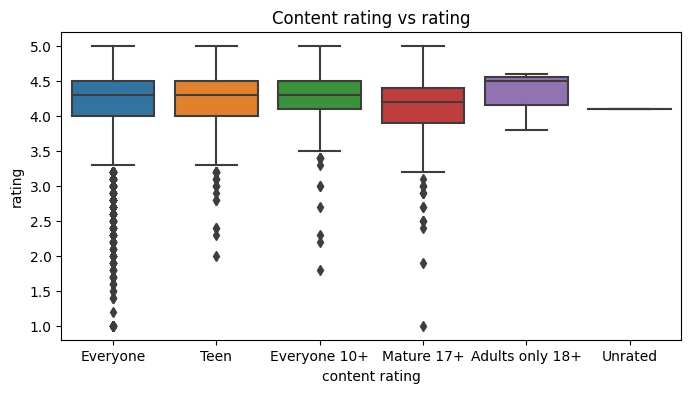

In [217]:
fig, ax = plt.subplots(figsize=(8,4))
ax=sns.boxplot(x='content rating', y='rating', data=df_clean)
ax.set_title('Content rating vs rating')
plt.show()

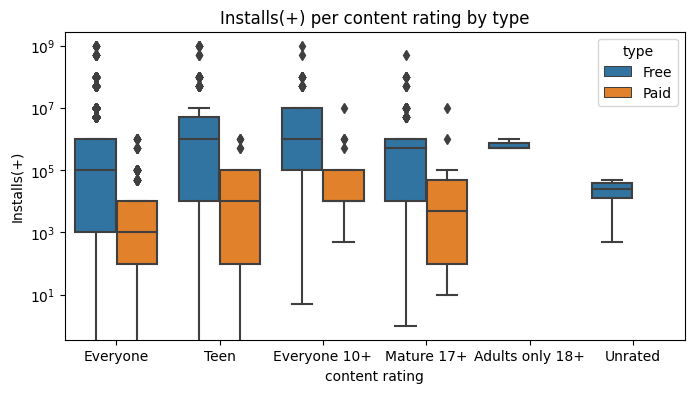

In [218]:
fig, ax = plt.subplots(figsize=(8,4))
ax=sns.boxplot(x='content rating', y='Installs(+)', hue='type', data=df_clean)
ax.set_title('Installs(+) per content rating by type')
ax.set_yscale('log')
plt.show()

## App Genres column analysis

In [219]:
df_clean['genres'].value_counts()

genres
Tools                              825
Entertainment                      556
Education                          508
Business                           419
Medical                            385
                                  ... 
Art & Design;Pretend Play            1
Lifestyle;Pretend Play               1
Comics;Creativity                    1
Art & Design;Action & Adventure      1
Strategy;Creativity                  1
Name: count, Length: 118, dtype: int64

## Last updated

In [220]:
df_clean['last updated']=pd.to_datetime(df_clean['last updated'])

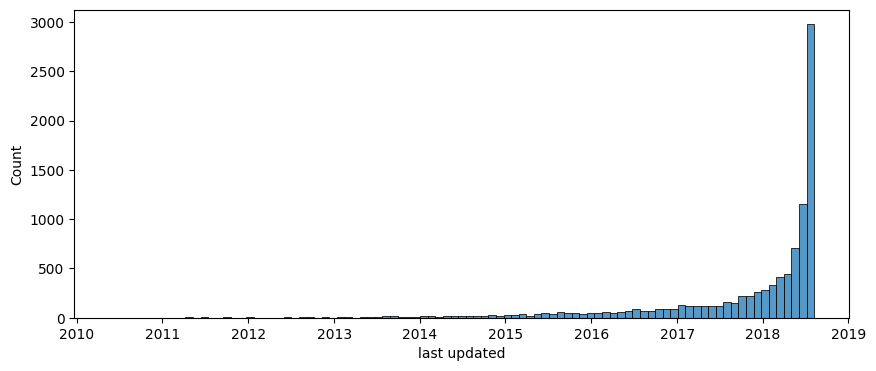

In [221]:
plt.figure(figsize=(10,4))
sns.histplot(x='last updated', data=df_clean)
plt.show()

In [222]:
df_clean['last_up_year']=df_clean['last updated'].dt.year

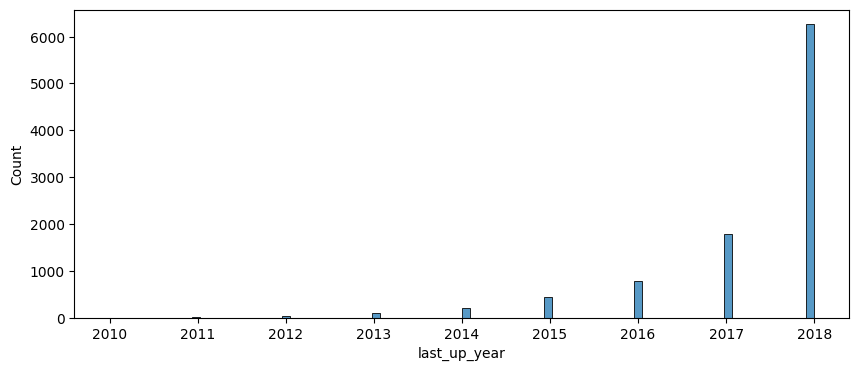

In [223]:
plt.figure(figsize=(10,4))
sns.histplot(x='last_up_year', data=df_clean)
plt.show()

## Current version column analysis

In [224]:
df_clean['current ver']

0                    1.0.0
1                    2.0.0
2                    1.2.4
3       Varies with device
4                      1.1
               ...        
9654                  1.48
9655                   1.0
9656                   1.0
9657    Varies with device
9658    Varies with device
Name: current ver, Length: 9620, dtype: object

In [225]:
df_clean['current ver'] = df_clean['current ver'].replace('Varies with device', 'NaN', regex=True)

In [226]:
df_clean['current ver'].value_counts()

current ver
NaN           1055
1.0            787
1.1            260
1.2            175
2.0            148
              ... 
4.20.1           1
v150             1
2.5.1.7592       1
2.27.1           1
2.0.148.0        1
Name: count, Length: 2810, dtype: int64

In [227]:
df_clean['current vers']=df_clean['current ver'].str.extract(r'^(\d+).', ).astype(float)

In [228]:
df_clean['current vers'].value_counts()

current vers
1.0          4200
2.0          1391
3.0           813
4.0           542
5.0           351
             ... 
100900.0        1
190000.0        1
1805.0          1
263.0           1
2017092.0       1
Name: count, Length: 91, dtype: int64

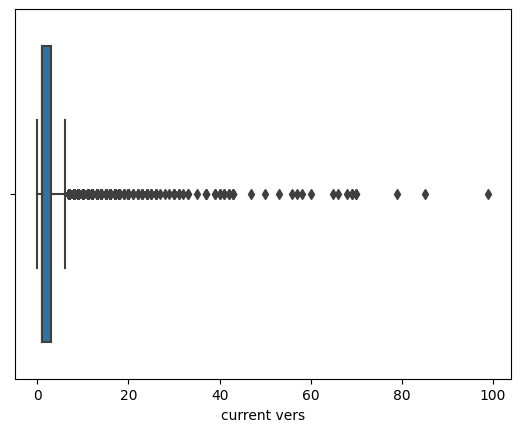

In [229]:
sns.boxplot(x='current vers', data=df_clean.loc[df_clean['current vers']<100])
plt.show()

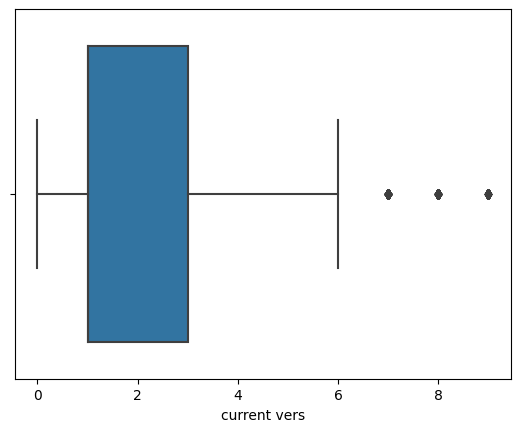

In [230]:
sns.boxplot(x='current vers', data=df_clean.loc[df_clean['current vers']<10])
plt.show()

In [231]:
print('Total apps', len(df_clean))
print('Number of apps with current version lower than 1000:', len(df_clean.loc[df_clean['current vers']<1000]))
print('Number of apps with current version lower than 100:', len(df_clean.loc[df_clean['current vers']<100]))
print('Number of apps with current version lower than 10:', len(df_clean.loc[df_clean['current vers']<10]))
print('Number of apps with current version lower than 6:', len(df_clean.loc[df_clean['current vers']<6]))

Total apps 9620
Number of apps with current version lower than 1000: 8278
Number of apps with current version lower than 100: 8270
Number of apps with current version lower than 10: 7997
Number of apps with current version lower than 6: 7453


In [232]:
df_clean=df_clean.drop('current ver', axis=1)

In [233]:
df_clean=df_clean.loc[df_clean['current vers']<6]

## Android version

In [234]:
df_clean['android ver']

0       4.0.3 and up
1       4.0.3 and up
2       4.0.3 and up
4         4.4 and up
5         2.3 and up
            ...     
9652      4.1 and up
9653      4.0 and up
9654      4.1 and up
9655      4.1 and up
9656      2.2 and up
Name: android ver, Length: 7453, dtype: object

In [235]:
df_clean['android vers']=df_clean['android ver'].replace('and up', '', regex=True)

In [236]:
df_clean.drop('android ver', axis=1,inplace=True)

In [237]:
df_clean['android vers'].value_counts()

android vers
4.1                   1917
4.0.3                 1130
4.0                   1119
4.4                    680
2.3                    567
5.0                    390
4.2                    303
2.3.3                  252
2.2                    218
3.0                    214
4.3                    184
2.1                    125
1.6                     93
6.0                     45
Varies with device      42
7.0                     36
3.2                     31
2.0                     26
5.1                     20
1.5                     18
4.4W                    10
3.1                      9
2.0.1                    7
8.0                      5
7.1                      2
5.0 - 8.0                2
1.0                      2
7.0 - 7.1.1              1
4.1 - 7.1.1              1
5.0 - 6.0                1
5.0 - 7.1.1              1
Name: count, dtype: int64

In [238]:
df_clean['android vers']=df_clean['android vers'].replace('Varies with device', '', regex=True).replace('W', '', regex=True).replace('', np.nan)
df_clean=df_clean.loc[df_clean['android vers'].str.contains(r'-') == False]

In [239]:
df_clean['android vers']=df_clean['android vers'].str.strip()

In [240]:
df_clean['android vers'].value_counts()

android vers
4.1      1917
4.0.3    1130
4.0      1119
4.4       690
2.3       567
5.0       390
4.2       303
2.3.3     252
2.2       218
3.0       214
4.3       184
2.1       125
1.6        93
6.0        45
7.0        36
3.2        31
2.0        26
5.1        20
1.5        18
3.1         9
2.0.1       7
8.0         5
7.1         2
1.0         2
Name: count, dtype: int64

In [241]:
df_clean['android vers'] = df_clean['android vers'].apply(lambda x: x[:3])

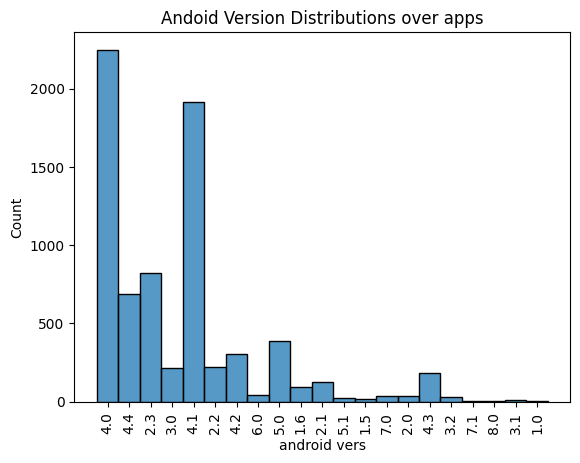

In [242]:
sns.histplot(x='android vers', data=df_clean)
plt.xticks(rotation=90);
plt.title('Andoid Version Distributions over apps')
plt.show()

In [243]:
df_clean['android vers_main']=df_clean['android vers'].str.extract(r'^(\d+).', ).astype(float)

In [244]:
df_clean['android vers_main'].value_counts()

android vers_main
4.0    5343
2.0    1195
5.0     410
3.0     254
1.0     113
6.0      45
7.0      38
8.0       5
Name: count, dtype: int64

Text(0.5, 1.0, 'Main Andoid Version by apps')

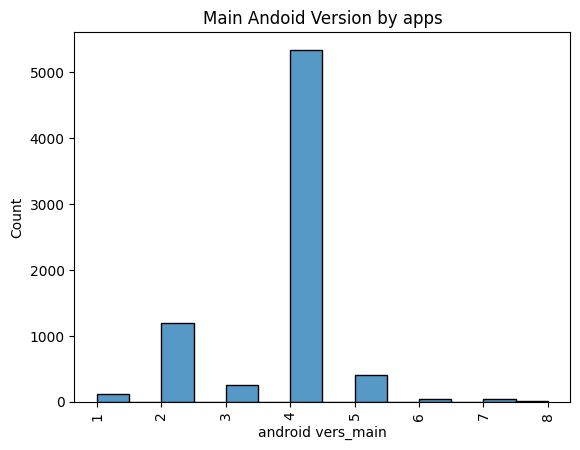

In [245]:
sns.histplot(x='android vers_main', data=df_clean)
plt.xticks(rotation=90);
plt.title('Main Andoid Version by apps')

In [246]:
df_clean = df_clean.loc[(df_clean['android vers_main'] >= 3)]

In [247]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6095 entries, 0 to 9655
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   app                6095 non-null   object        
 1   category           6095 non-null   object        
 2   rating             5029 non-null   float64       
 3   reviews            6095 non-null   int64         
 4   size(MB)           5961 non-null   float64       
 5   Installs(+)        6095 non-null   float64       
 6   type               6095 non-null   object        
 7   price              6095 non-null   float64       
 8   content rating     6095 non-null   object        
 9   genres             6095 non-null   object        
 10  last updated       6095 non-null   datetime64[ns]
 11  last_up_year       6095 non-null   int32         
 12  current vers       6095 non-null   float64       
 13  android vers       6095 non-null   object        
 14  android vers_

In [248]:
df_clean['android vers'] = df_clean['android vers'].astype(float)

# Q1 Do expensive apps have higher rating?

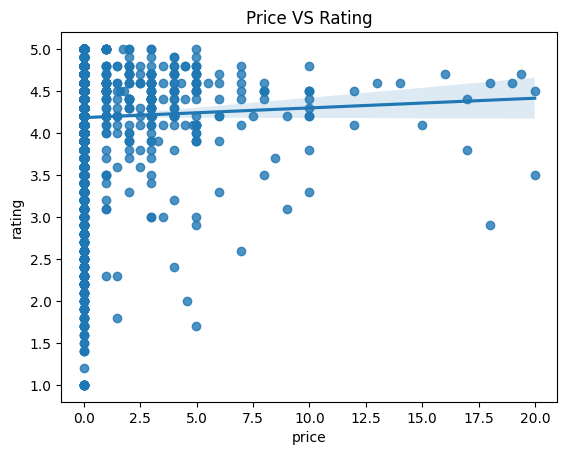

In [249]:
sns.regplot(x='price', y='rating', data=df_clean)
plt.title('Price VS Rating')
plt.show()

# Q2 Do apps with high rating have more reviews?

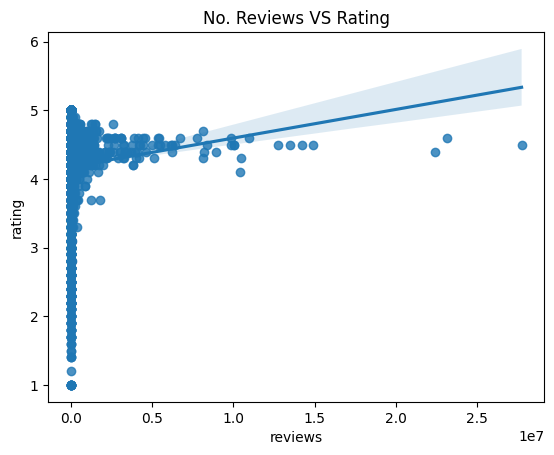

In [250]:
sns.regplot(y='rating', x='reviews', data=df_clean)
plt.title('No. Reviews VS Rating')
plt.show()

# Q3 Which category has more reviews?

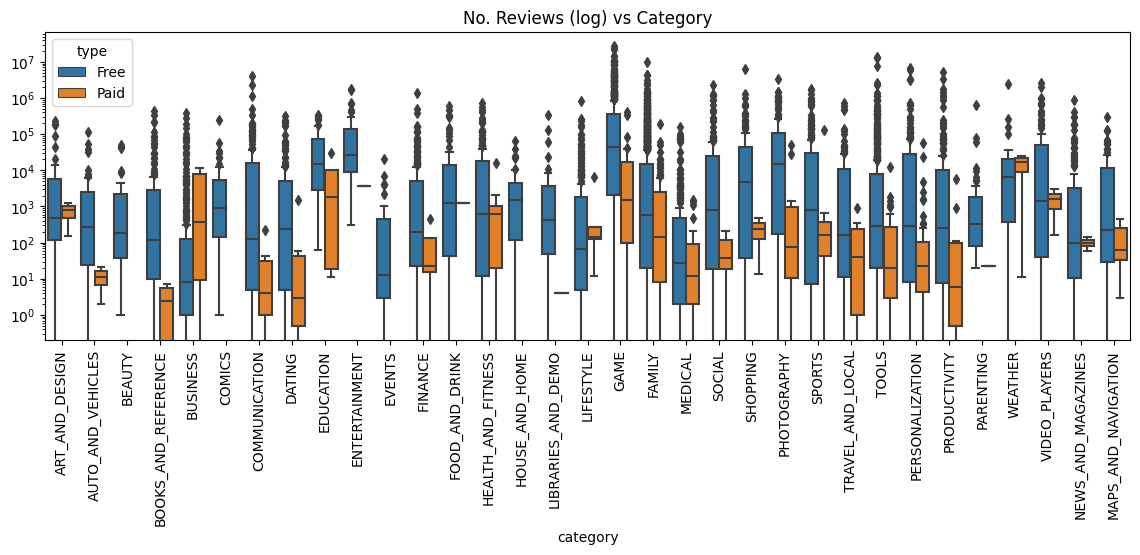

In [251]:
plt.figure(figsize=(14,4))
sns.boxplot(x='category', y='reviews', data=df_clean, hue='type')
plt.yscale('log')
plt.ylabel('')
plt.xticks(rotation=90);
plt.title('No. Reviews (log) vs Category')
plt.show()

# Q4 Which category has higher rating?

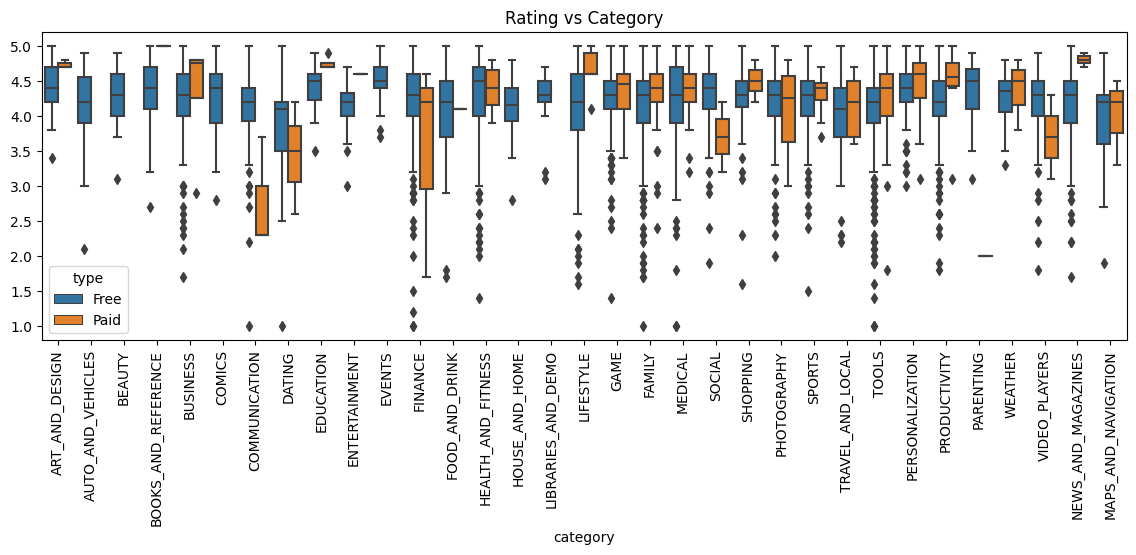

In [252]:
plt.figure(figsize=(14,4))
sns.boxplot(x='category', y='rating', data=df_clean, hue='type')
plt.xticks(rotation=90);
plt.title('Rating vs Category')
plt.ylabel('')
plt.show()

# Q5 Is there any relationship between the category and app size?

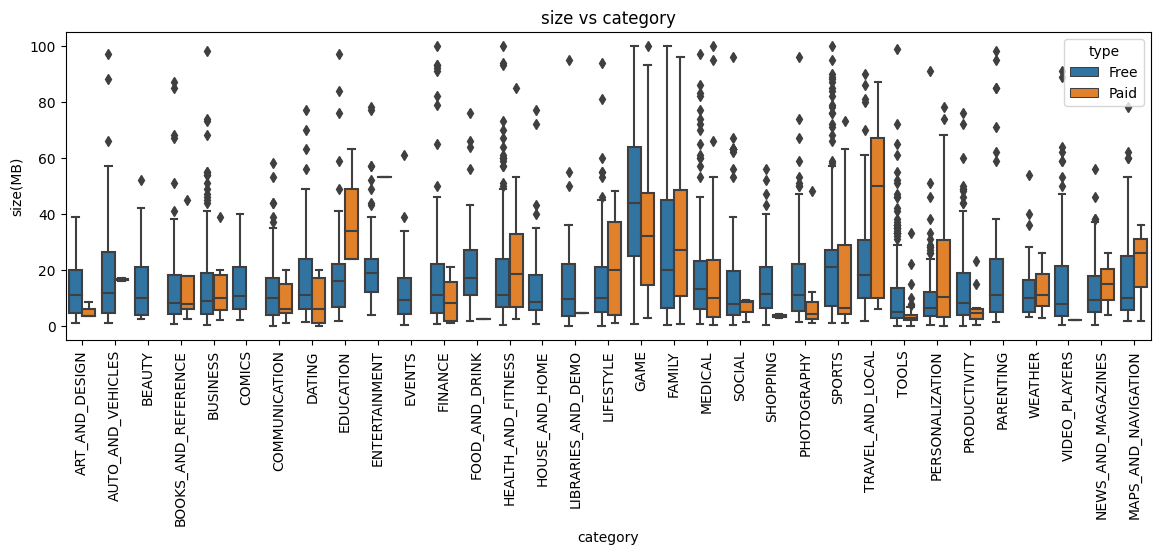

In [253]:
plt.figure(figsize=(14,4))
sns.boxplot(x='category', y='size(MB)', data=df_clean, hue='type')
plt.xticks(rotation=90);
plt.title('size vs category')
plt.show()

# Q6 Is there any relationship between app rating and size?

<Axes: xlabel='rating', ylabel='size(MB)'>

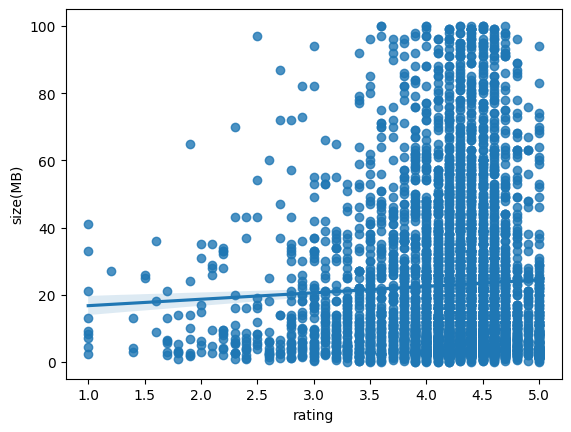

In [254]:
sns.regplot(x='rating', y='size(MB)', data=df_clean)

# Q7 Is there any relationship between No. Installs and Reviews?

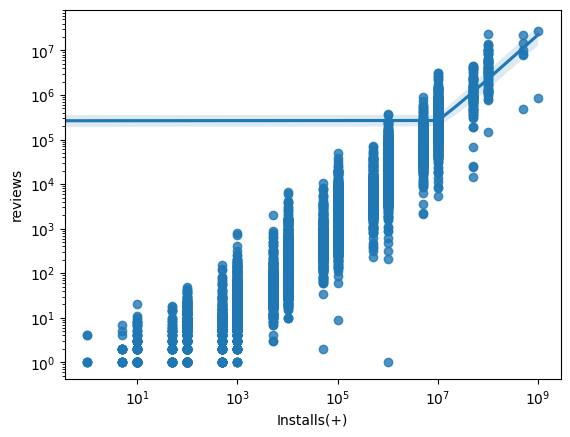

In [255]:
sns.regplot(x='Installs(+)',y='reviews', data=df_clean)
plt.yscale('log')
plt.xscale('log')

# App rating prediction

In [256]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6095 entries, 0 to 9655
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   app                6095 non-null   object        
 1   category           6095 non-null   object        
 2   rating             5029 non-null   float64       
 3   reviews            6095 non-null   int64         
 4   size(MB)           5961 non-null   float64       
 5   Installs(+)        6095 non-null   float64       
 6   type               6095 non-null   object        
 7   price              6095 non-null   float64       
 8   content rating     6095 non-null   object        
 9   genres             6095 non-null   object        
 10  last updated       6095 non-null   datetime64[ns]
 11  last_up_year       6095 non-null   int32         
 12  current vers       6095 non-null   float64       
 13  android vers       6095 non-null   float64       
 14  android vers_

In [257]:
df1=df_clean.copy()

In [258]:
df1=df1.drop(['app','last updated'], axis=1)

In [259]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6095 entries, 0 to 9655
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           6095 non-null   object 
 1   rating             5029 non-null   float64
 2   reviews            6095 non-null   int64  
 3   size(MB)           5961 non-null   float64
 4   Installs(+)        6095 non-null   float64
 5   type               6095 non-null   object 
 6   price              6095 non-null   float64
 7   content rating     6095 non-null   object 
 8   genres             6095 non-null   object 
 9   last_up_year       6095 non-null   int32  
 10  current vers       6095 non-null   float64
 11  android vers       6095 non-null   float64
 12  android vers_main  6095 non-null   float64
dtypes: float64(7), int32(1), int64(1), object(4)
memory usage: 642.8+ KB


In [260]:
df1.head()

,category,rating,reviews,size(MB),Installs(+),type,price,content rating,genres,last_up_year,current vers,android vers,android vers_main
0,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,2018,1.0,4.0,4.0
1,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018,2.0,4.0,4.0
2,ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,2018,1.0,4.0,4.0
4,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,2018,1.0,4.4,4.0
6,ART_AND_DESIGN,3.8,178,19.0,50000.0,Free,0.0,Everyone,Art & Design,2018,1.0,4.0,4.0


In [261]:
df1.describe()

,rating,reviews,size(MB),Installs(+),price,last_up_year,current vers,android vers,android vers_main
count,5029.000000,6.095000e+03,5961.000000,6.095000e+03,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000
mean,4.184908,1.286847e+05,21.254512,3.920303e+06,0.239165,2017.538802,1.844791,4.159606,4.062346
std,0.565806,8.832910e+05,22.251823,2.686603e+07,1.299353,0.826872,1.228235,0.454986,0.451506
min,1.000000,0.000000e+00,0.008500,0.000000e+00,0.000000,2012.000000,0.000000,3.000000,3.000000
25%,4.000000,1.400000e+01,5.100000,1.000000e+03,0.000000,2017.000000,1.000000,4.000000,4.000000
50%,4.300000,4.380000e+02,13.000000,5.000000e+04,0.000000,2018.000000,1.000000,4.100000,4.000000
75%,4.500000,1.473150e+04,29.000000,1.000000e+06,0.000000,2018.000000,2.000000,4.200000,4.000000
max,5.000000,2.772226e+07,100.000000,1.000000e+09,19.990000,2018.000000,5.000000,8.000000,8.000000


In [262]:
df1['Installs(+)']=np.log(df_clean['Installs(+)'] + 1)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


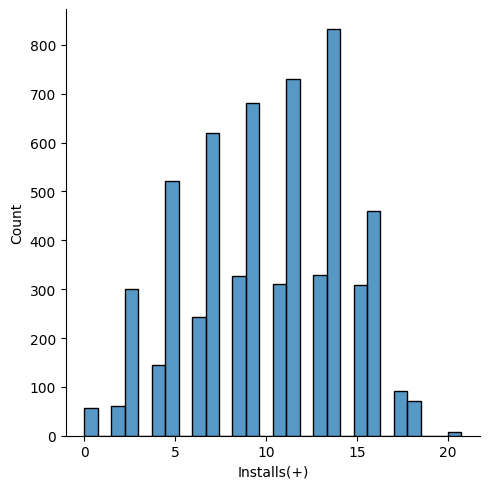

In [263]:
sns.displot(df1['Installs(+)'])

In [264]:
df1.drop('android vers_main', axis = 1, inplace=True)

## Categorical features Encoding

In [265]:
df1['type'] = df1['type'].replace({'Free':0, "Paid":1})

In [266]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6095 entries, 0 to 9655
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        6095 non-null   object 
 1   rating          5029 non-null   float64
 2   reviews         6095 non-null   int64  
 3   size(MB)        5961 non-null   float64
 4   Installs(+)     6095 non-null   float64
 5   type            6095 non-null   int64  
 6   price           6095 non-null   float64
 7   content rating  6095 non-null   object 
 8   genres          6095 non-null   object 
 9   last_up_year    6095 non-null   int32  
 10  current vers    6095 non-null   float64
 11  android vers    6095 non-null   float64
dtypes: float64(6), int32(1), int64(2), object(3)
memory usage: 595.2+ KB


In [267]:
en = LabelEncoder()
catCols =  ['category','content rating','genres']
for cols in catCols:
    df1[cols] = en.fit_transform(df1[cols])

In [268]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6095 entries, 0 to 9655
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        6095 non-null   int64  
 1   rating          5029 non-null   float64
 2   reviews         6095 non-null   int64  
 3   size(MB)        5961 non-null   float64
 4   Installs(+)     6095 non-null   float64
 5   type            6095 non-null   int64  
 6   price           6095 non-null   float64
 7   content rating  6095 non-null   int64  
 8   genres          6095 non-null   int64  
 9   last_up_year    6095 non-null   int32  
 10  current vers    6095 non-null   float64
 11  android vers    6095 non-null   float64
dtypes: float64(6), int32(1), int64(5)
memory usage: 595.2 KB


In [269]:
imputer = KNNImputer(n_neighbors=3)
df1 = pd.DataFrame(imputer.fit_transform(df1),columns = df1.columns)

In [270]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        6095 non-null   float64
 1   rating          6095 non-null   float64
 2   reviews         6095 non-null   float64
 3   size(MB)        6095 non-null   float64
 4   Installs(+)     6095 non-null   float64
 5   type            6095 non-null   float64
 6   price           6095 non-null   float64
 7   content rating  6095 non-null   float64
 8   genres          6095 non-null   float64
 9   last_up_year    6095 non-null   float64
 10  current vers    6095 non-null   float64
 11  android vers    6095 non-null   float64
dtypes: float64(12)
memory usage: 571.5 KB


In [271]:
df1.head()

,category,rating,reviews,size(MB),Installs(+),type,price,content rating,genres,last_up_year,current vers,android vers
0,0.0,4.1,159.0,19.0,9.210440,0.0,0.0,1.0,9.0,2018.0,1.0,4.0
1,0.0,3.9,967.0,14.0,13.122365,0.0,0.0,1.0,12.0,2018.0,2.0,4.0
2,0.0,4.7,87510.0,8.7,15.424949,0.0,0.0,1.0,9.0,2018.0,1.0,4.0
3,0.0,4.3,967.0,2.8,11.512935,0.0,0.0,1.0,11.0,2018.0,1.0,4.4
4,0.0,3.8,178.0,19.0,10.819798,0.0,0.0,1.0,9.0,2018.0,1.0,4.0


In [272]:
X=df1.drop('rating', axis = 1).values

In [273]:
y=df1['rating'].values

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [275]:
scaler = MinMaxScaler()

In [276]:
scaler.fit(X_train)

MinMaxScaler()

In [277]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)            

In [278]:
rf = RandomForestRegressor()

In [279]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [280]:
y_pred_rf = rf.predict(X_test)

In [281]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("RMSE using RF: ", np.sqrt(mse_rf))

RMSE using RF:  0.4746848582875225


In [282]:
feature_name_list=df1.drop('rating', axis = 1).columns

In [283]:
rf.feature_names = feature_name_list

Text(0.5, 0, 'Feature Importance (%)')

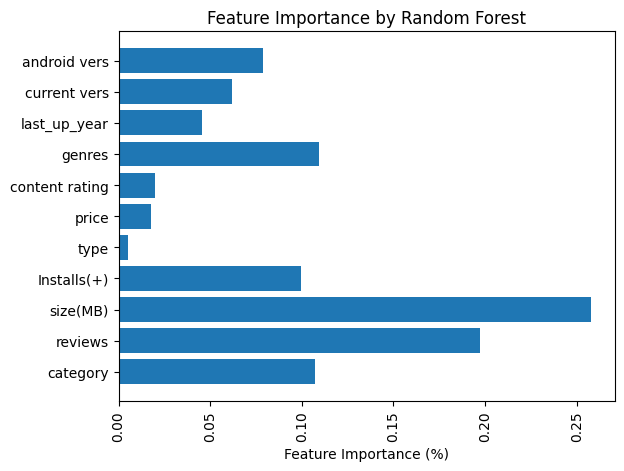

In [284]:
plt.barh(rf.feature_names,rf.feature_importances_)
plt.xticks(rotation=90);
plt.title('Feature Importance by Random Forest')
plt.xlabel('Feature Importance (%)')

## XGBoost

In [285]:
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.01)
xgb.fit(X_train, y_train) 
y_pred_xgb = xgb.predict(X_test) 
mse_xgb = mean_squared_error(y_pred_xgb, y_test)

# Rating prediction Summary

In [286]:
xgb.feature_names = feature_name_list

In [287]:
print(r"RMSE with RF: {:.3f}".format(np.sqrt(mse_rf)))
print(r"RMSE with XGBoost: {:.3f}".format(np.sqrt(mse_xgb)))

RMSE with RF: 0.475
RMSE with XGBoost: 0.487


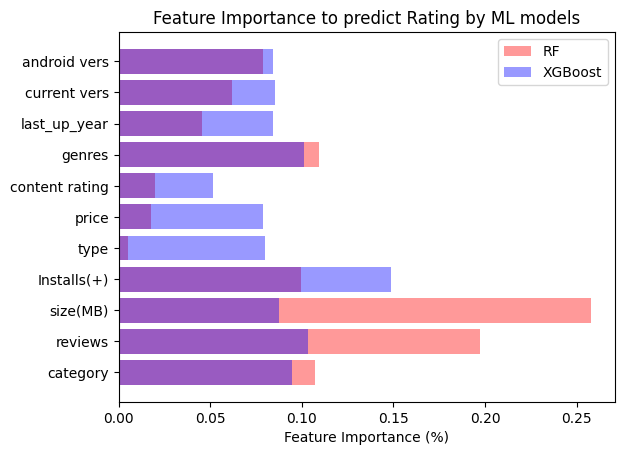

In [288]:
plt.barh(rf.feature_names,rf.feature_importances_, alpha=0.4, label='RF', color='red')
plt.barh(xgb.feature_names,xgb.feature_importances_, alpha=0.4, label='XGBoost', color='blue')
plt.legend(loc='upper right');
plt.title('Feature Importance to predict Rating by ML models')
plt.xlabel('Feature Importance (%)')
plt.show()